In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
p = RollRig.base_params(3)

In [3]:
sm = mf.SymbolicModel.from_file('RollRigModel.py')
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[2]))})

In [4]:
p.c.value = 0.067
p.s.value = 1
p.sigma.value = 0.28
p.m_w.value = 0.22
p.m_f.value = 0.038
p.m_l.value = 0#0.0275
p.alpha_r.value = 0
p.c_d_max.value = 1
p.a_0.value = 2*np.pi
p.a_1.value = 2*np.pi
#p.tau.value = 0
p.alpha_r.value = 0
p.w_g.value = 0
p.beta.value = 0.0036
p.V.value = 22.5

p.Lambda.value = np.deg2rad(10)

In [5]:
nm = mf.NumericModel.from_SymbolicModel(p,sm)
ext_f = nm.ExtForces.force_funcs[0]

torque_period = 0.1
torque_max = p.beta.value*p.V.value**2

def torque(tup,x,t):
    if t<2:
        return 0
    elif t<torque_period/2+2:
        return torque_max*0.5*(1- np.cos(2*np.pi*(t-2)/torque_period))
    else:
        return torque_max
    
def custom_force(tup,x,t):
    return np.array([[torque(tup,x,t)],[0],[0]])

nm.ExtForces.force_funcs = [ext_f , custom_force]



In [6]:
import plotly.graph_objects as go
import plotly as pl
def surface_plot_roll_rate(velocity,roll,flare,camber):
    from scipy.interpolate import griddata
    
    roll_rates = np.linspace(0,720,21)
    fold = np.linspace(-100,100,121)
    data = []
    p.V.value = velocity
    p.Lambda.value = np.deg2rad(flare)
    p.alpha_c.value = np.deg2rad(camber)
    y = [0,0,0,0,0,0]
    t = 0
    # create the data points
    for r_i in roll_rates:
        for fold_i in fold:
            y[0] = np.deg2rad(roll)
            y[1] = np.deg2rad(r_i)
            y[2] = np.deg2rad(fold_i)
            y[4] = np.deg2rad(fold_i)
            res = nm.deriv(t,y,p.GetNumericTuple(y,t))
            data.append({'Roll Rate [Deg/s]':r_i,'Fold Angle [Deg]':fold_i,'FWT Acceleration [Deg/s^2]':np.rad2deg(res[3])})
    df = pd.DataFrame(data)
    
    # interpolate onto a regular grid
    grid_x, grid_y = np.mgrid[0:max(roll_rates), min(fold):max(fold)]
    
    points = df[['Roll Rate [Deg/s]','Fold Angle [Deg]']].to_numpy()
    values = df['FWT Acceleration [Deg/s^2]']
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='linear')
    grid_z0 = np.clip(grid_z0,-np.amax(abs(grid_z0))*0.3,np.amax(abs(grid_z0))*0.3)
    fig, (ax1) = plt.subplots(figsize=(8,8),nrows=1,facecolor='w', edgecolor='k')
    ax1.contour(grid_x, grid_y, grid_z0, levels=40, linewidths=0.5, colors='k')
    cntr1 = ax1.contourf(grid_x, grid_y, grid_z0, levels=20, cmap="RdBu_r")
    fig.colorbar(cntr1, ax=ax1)
    plt.xlabel('Roll Rate [Deg/s]', fontsize=18)
    plt.ylabel('Fold Angle [Deg]', fontsize=18)
    plt.title(f'V={velocity}, Rol={roll}, Flare={flare}, Camber={camber}')
    return fig

def surface_plot_roll(velocity,roll_rate,flare,camber):
    from scipy.interpolate import griddata
    
    rolls = np.linspace(-180,180,37)
    fold = np.linspace(-100,100,121)
    data = []
    p.V.value = velocity
    p.Lambda.value = np.deg2rad(flare)
    p.alpha_c.value = np.deg2rad(camber)
    y = [0,0,0,0,0,0]
    t = 0
    # create the data points
    for r_i in rolls:
        for fold_i in fold:
            y[0] = np.deg2rad(r_i)
            y[1] = np.deg2rad(roll_rate)
            y[2] = np.deg2rad(fold_i)
            y[4] = np.deg2rad(fold_i)
            res = nm.deriv(t,y,p.GetNumericTuple(y,t))
            data.append({'Roll Rate [Deg/s]':roll_rate,'Roll [Deg]':r_i,'Fold Angle [Deg]':fold_i,'FWT Acceleration [Deg/s^2]':np.rad2deg(res[3])})
    df = pd.DataFrame(data)
    
    # interpolate onto a regular grid
    grid_x, grid_y = np.mgrid[min(rolls):max(rolls), min(fold):max(fold)]
    points = df[['Roll [Deg]','Fold Angle [Deg]']].to_numpy()
    values = df['FWT Acceleration [Deg/s^2]']
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='linear')
    # grid_z0 = np.clip(grid_z0,-np.amax(abs(grid_z0))*0.2,np.amax(abs(grid_z0))*0.2)
    fig, (ax1) = plt.subplots(figsize=(8,8),nrows=1,facecolor='w', edgecolor='k')
    ax1.contour(grid_x, grid_y, grid_z0, levels=20, linewidths=0.5, colors='k')
    cntr1 = ax1.contourf(grid_x, grid_y, grid_z0, levels=20, cmap="RdBu_r")
    fig.colorbar(cntr1, ax=ax1)
    plt.xlabel('Roll Angle [Deg]', fontsize=18)
    plt.ylabel('Fold Angle [Deg]', fontsize=18)
    plt.title(f'V={velocity}, Roll Rate={roll_rate}, Flare={flare}, Camber={camber}')
    return fig
#     plt.imshow(grid_z0.T,extent=(0,700,-90,90), origin='lower')
#     plt.imshow(grid_z0.T,extent=(0,700,-90,90), origin='lower')

Column
    [0] Column
        [0] IntSlider(end=30, name='velocity', step=5, value=15)
        [1] IntSlider(end=720, name='roll_rate', step=30, value=180)
        [2] IntSlider(end=30, name='flare', start=10, step=10, value=10)
        [3] IntSlider(end=10, name='camber', start=-10, step=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00006')
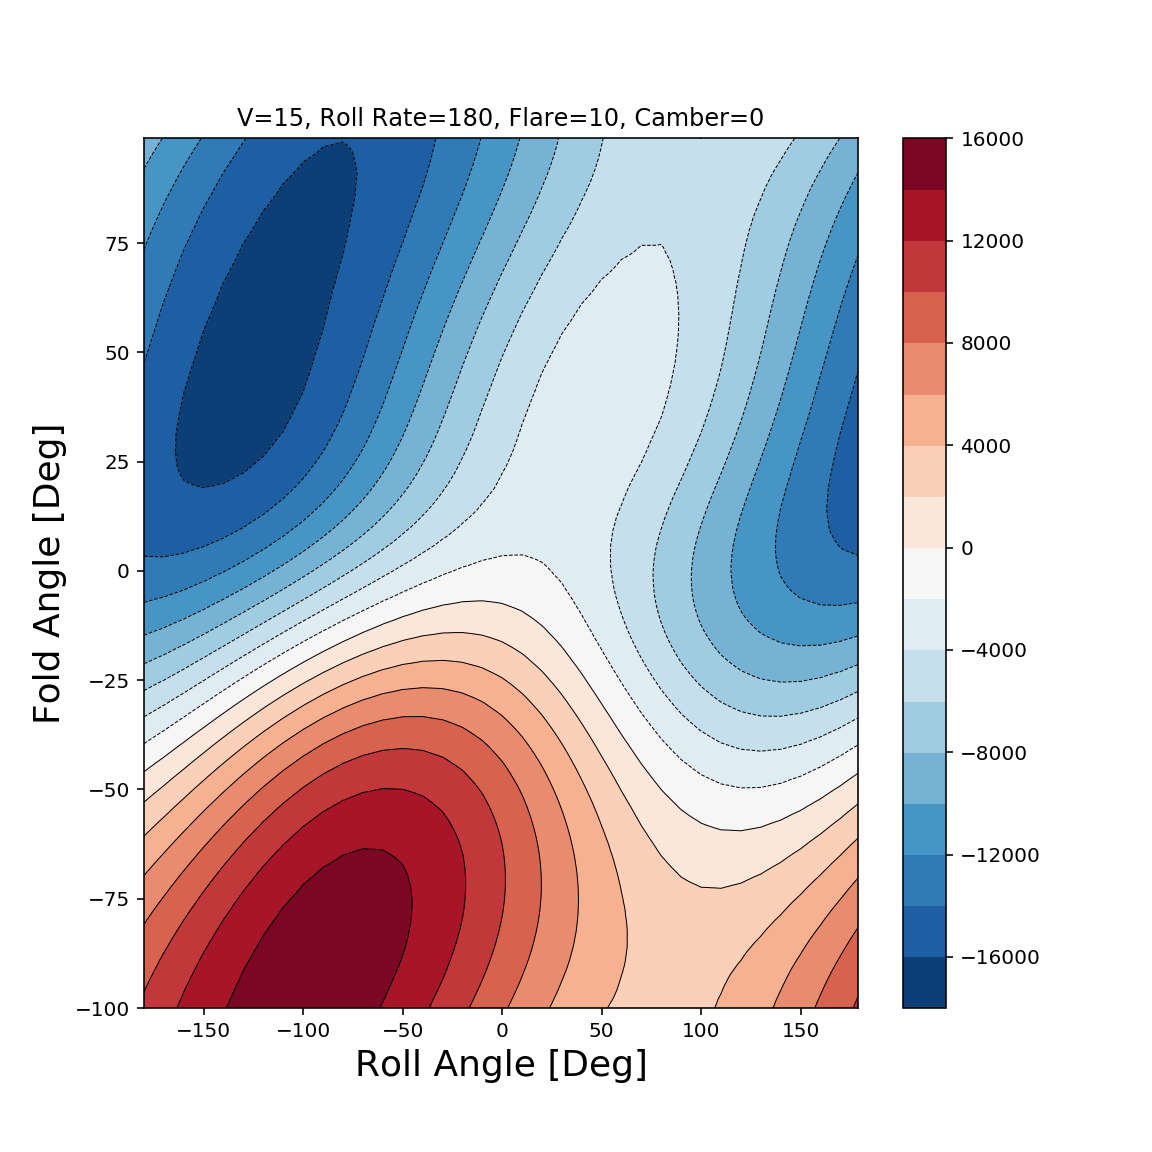

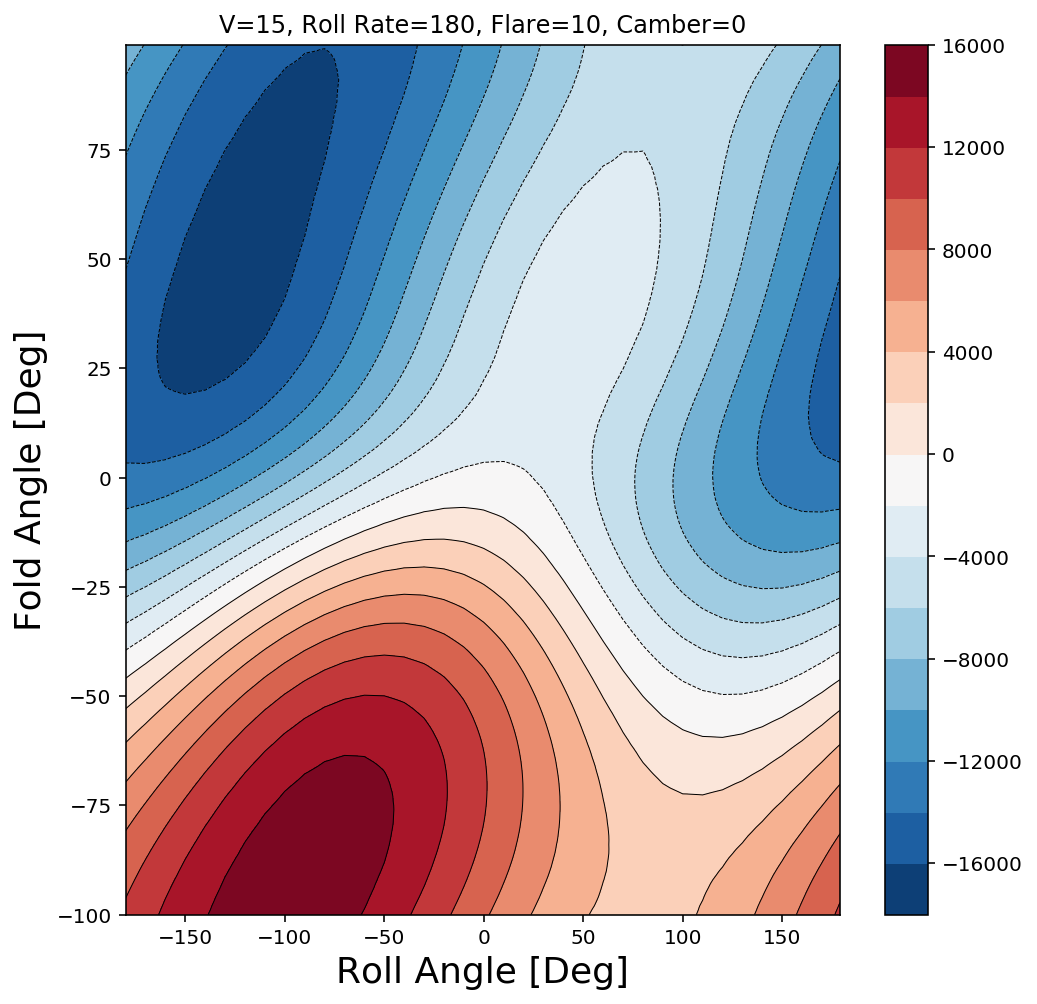

In [7]:
import panel as pn
from panel.interact import interact
pn.extension()

interact(surface_plot_roll,velocity =(0,30,5,15),
         roll_rate = (0,720,30,180),
         flare = (10,30,10,10),
         camber = (-10,10,10,0)
        )

Column
    [0] Column
        [0] IntSlider(end=30, name='velocity', step=5, value=15)
        [1] IntSlider(end=180, name='roll', start=-180, step=10)
        [2] IntSlider(end=30, name='flare', start=10, step=10, value=10)
        [3] IntSlider(end=10, name='camber', start=-10, step=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00033')
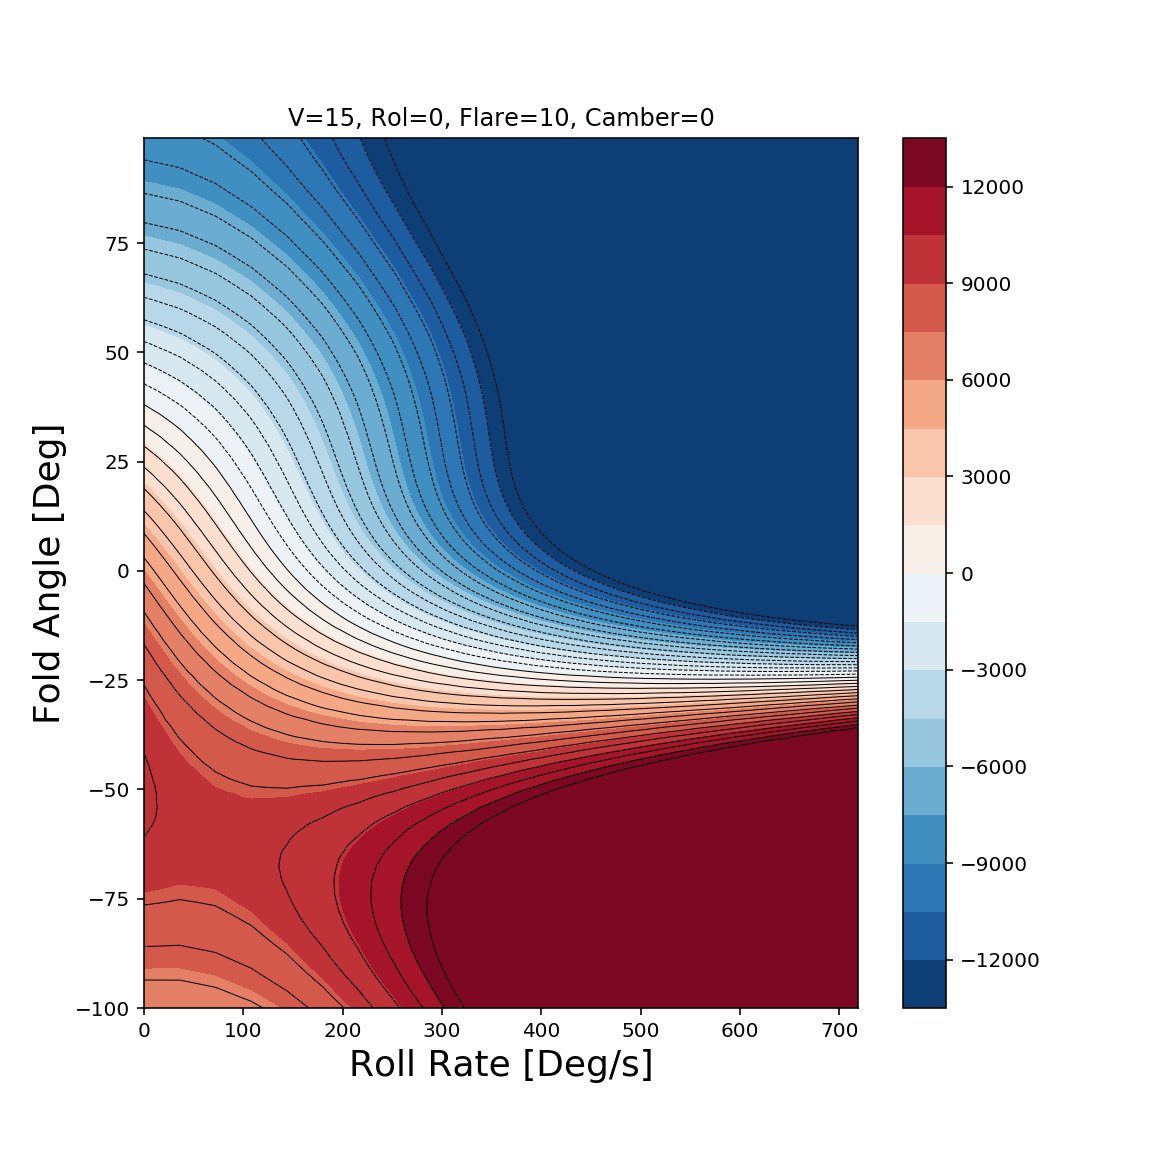

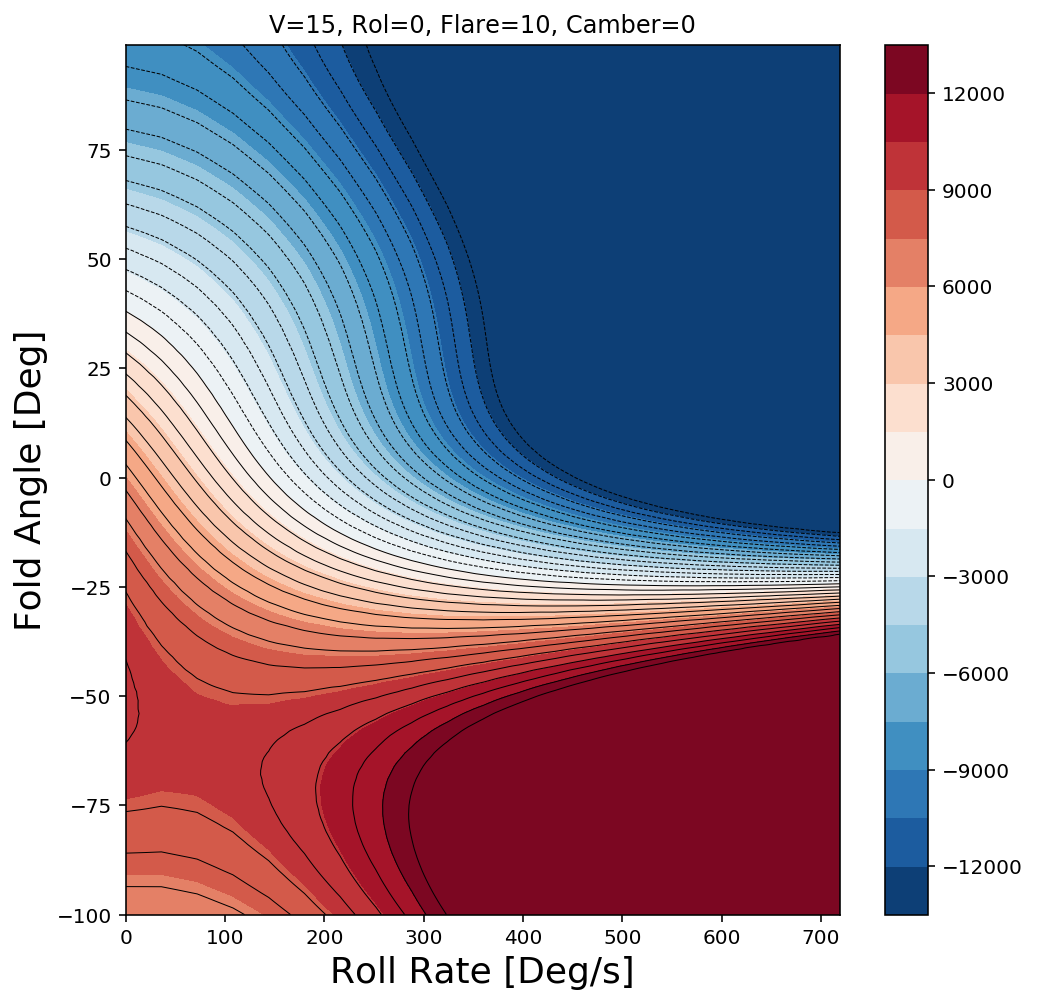

In [10]:
interact(surface_plot_roll_rate,velocity =(0,30,5,15),
         roll = (-180,180,10,0),
         flare = (10,30,10,10),
         camber = (-10,10,10,0)
        )

Column
    [0] Column
        [0] IntSlider(end=30, name='velocity', step=5, value=15)
        [1] IntSlider(end=180, name='roll', start=-180, step=10)
        [2] IntSlider(end=30, name='flare', start=10, step=10, value=10)
        [3] IntSlider(end=10, name='camber', start=-10, step=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00045')
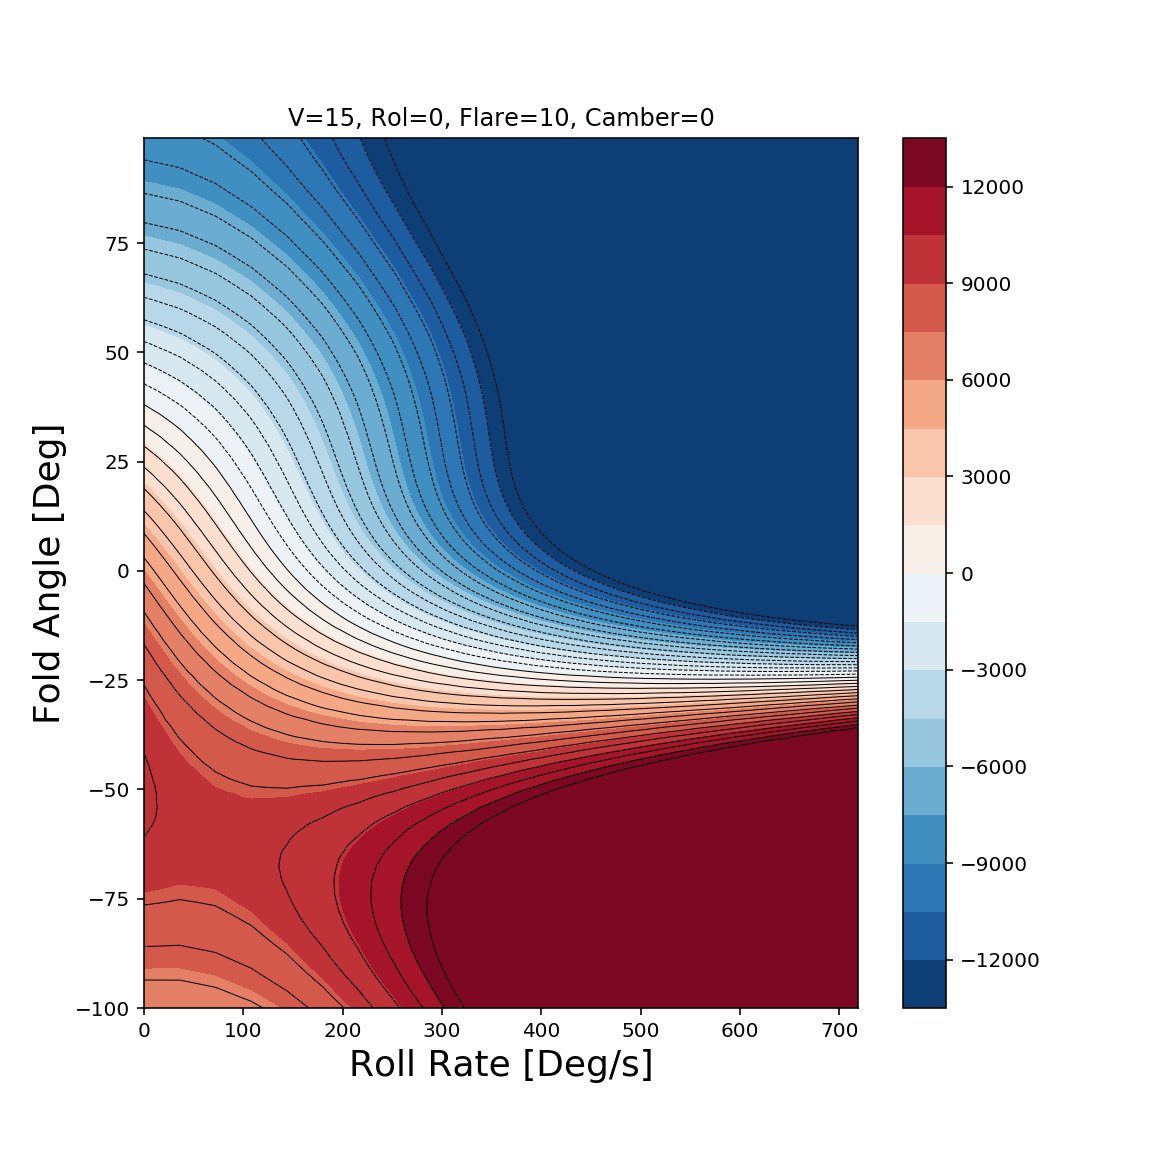

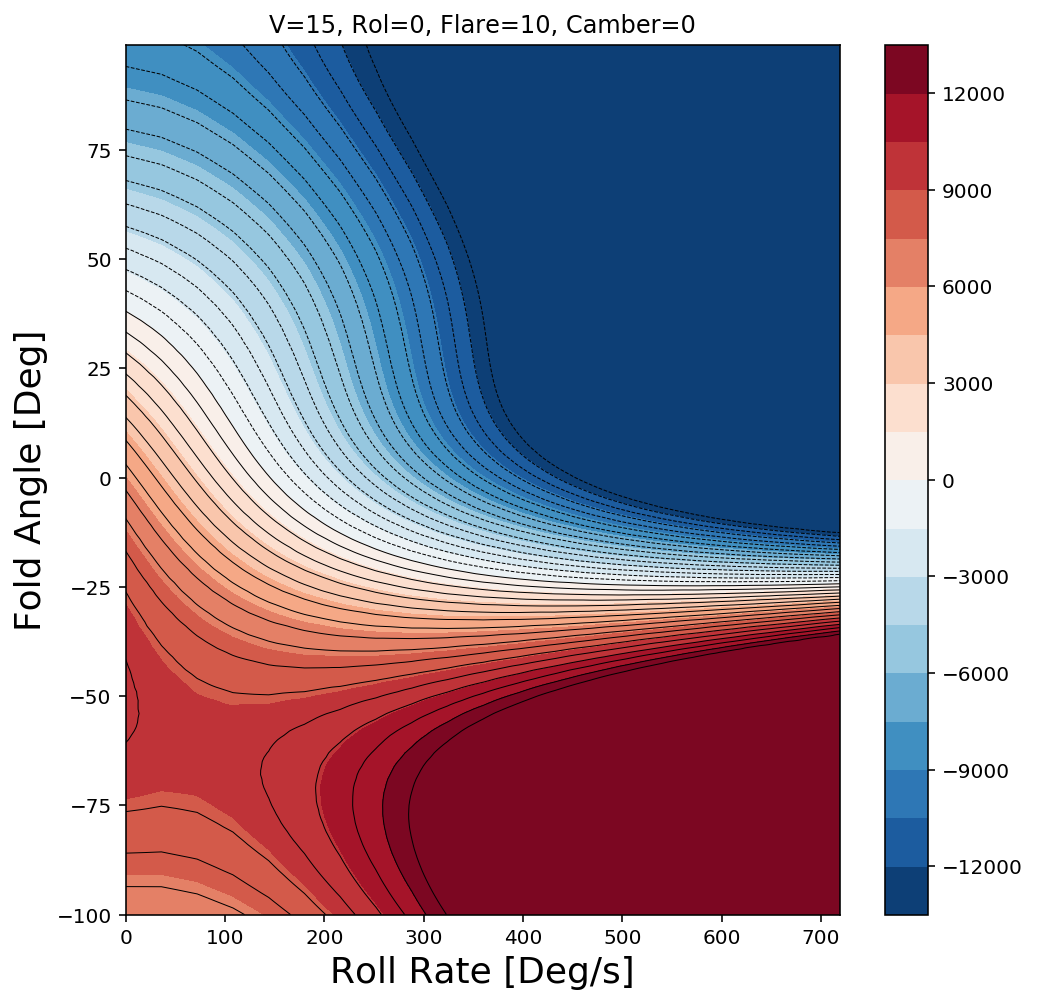

In [11]:
interact(surface_plot_roll_rate,velocity =(0,30,5,15),
         roll = (-180,180,10,0),
         flare = (10,30,10,10),
         camber = (-10,10,10,0)
        )


In [47]:
from scipy.optimize import minimize
# create data frame for coast angle with roll rate, flare, velocity and camber
rolls = np.linspace(-180,180,11)
roll_rate = np.linspace(0,720,11)
flare = np.array([10,20,30])
camber = np.array([0])
velocity = np.array([15,20,25,30])


configs = np.array(np.meshgrid(rolls,flare,camber,velocity,roll_rate)).T.reshape(-1,5)


def objective_func(x,roll,roll_rate,index):
    y=[0]*6
    y[0] = roll
    y[1] = roll_rate
    y[2] = np.deg2rad(x[0])
    res = nm.deriv(0,y,p.GetNumericTuple(y,0))
    return res[index]**2

data = []
for config in configs[:,:]:
    p.V.value = config[3]
    p.Lambda.value = np.deg2rad(config[1])
    p.alpha_c.value = np.deg2rad(config[2])
    t = 0
    args = (np.deg2rad(config[0]),np.deg2rad(config[4]))
    # find a good initial guess
    folds = np.linspace(-90,90,15)   
    f = lambda x,index : [objective_func([x_i],*args,index) for x_i in x]
    res_left = minimize(objective_func,[folds[np.argmin(f(folds,3))]],args = (*args,3),bounds =((-90,90),))
    res_right = minimize(objective_func,[folds[np.argmin(f(folds,5))]],args = (*args,5),bounds =((-90,90),))
    if res_left.success and res_right.success:
        y = [*args,np.deg2rad(res_left.x[0]),0,np.deg2rad(res_right.x[0]),0]
        print(nm.deriv(0,y,p.GetNumericTuple(y,0)))
        torq = nm.deriv(0,y,p.GetNumericTuple(y,0))[1]
    else:
        torq = np.nan
    
    data.append({"V":config[3],"Flare":config[1],"Camber":config[2],"Roll":config[0],
                    "Roll Rate":config[4],
                    "Coast_left":res_left.x[0] if res_left.success else np.nan,
                    "Coast_right":res_right.x[0] if res_right.success else np.nan,
                    "Torque":torq}) 
#     # create the data points
#     for r_i in rolls:
#         for fold_i in fold:
#             y[0] = np.deg2rad(r_i)
#             y[1] = np.deg2rad(roll_rate)
#             y[2] = np.deg2rad(fold_i)
#             y[4] = np.deg2rad(fold_i)
#             res = nm.deriv(t,y,p.GetNumericTuple(y,t))
#             data.append({'Roll Rate [Deg/s]':roll_rate,'Roll [Deg]':r_i,'Fold Angle [Deg]':fold_i,'FWT Acceleration [Deg/s^2]':np.rad2deg(res[3])})
#     df = pd.DataFrame(data)

1.309733552923255, -0.644453538312601, 0, -1.4337066864597354, 0]
[-3.141592653589793, 11.309733552923255, -0.5758302273422959, 0, -1.53886977997526, 0]
[-3.141592653589793, 11.309733552923255, -0.5299296771650174, 0, -1.5707963267948966, 0]
[-2.5132741228718345, 11.309733552923255, -0.5948197724388985, 0, -1.398991542311671, 0]
[-2.5132741228718345, 11.309733552923255, -0.5346062133359768, 0, -1.5024364846872555, 0]
[-2.5132741228718345, 11.309733552923255, -0.49336098236365966, 0, -1.5707963267948966, 0]
[-1.8849555921538759, 11.309733552923255, -0.5416729925717195, 0, -1.371194263572206, 0]
[-1.8849555921538759, 11.309733552923255, -0.487972347371662, 0, -1.4762599447669755, 0]
[-1.8849555921538759, 11.309733552923255, -0.45047996490648023, 0, -1.565084738691904, 0]
[-1.2566370614359172, 11.309733552923255, -0.500148972488514, 0, -1.3598330489468318, 0]
[-1.2566370614359172, 11.309733552923255, -0.44977449341729026, 0, -1.4702816385570143, 0]
[-1.2566370614359172, 11.309733552923255

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f9bb94e4f10&gt;

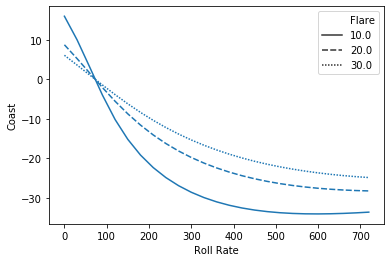

In [41]:
df = pd.DataFrame(data)
sns.lineplot(data=df[(df['Roll']==0) & (df['V']==30.0)],x='Roll Rate',y='Coast',style='Flare')


In [42]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparison/CoastData.csv', index = False)

[&lt;matplotlib.lines.Line2D at 0x7f9bb706e710&gt;]

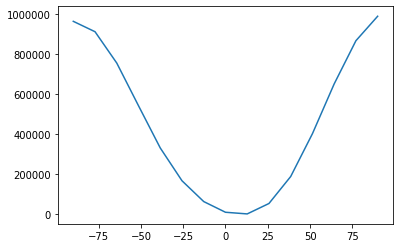

In [37]:
rolls = np.array([0])
roll_rate = np.array([0])
flare = np.array([20])
camber = np.array([0])
velocity = np.array([30])

configs = np.array(np.meshgrid(rolls,flare,camber,velocity,roll_rate)).T.reshape(-1,5)

for config in configs[:,:]:
    p.V.value = config[3]
    p.Lambda.value = np.deg2rad(config[1])
    p.alpha_c.value = np.deg2rad(config[2])
    t = 0
    args = (np.deg2rad(config[0]),np.deg2rad(config[4]))
    # find a good initial guess
    folds = np.linspace(-90,90,15)   
    f = lambda x : [objective_func([x_i],*args) for x_i in x]
    val = f(folds)

plt.plot(folds,val)


In [38]:
res = minimize(objective_func,[folds[np.argmin(f(folds))]],args = args,bounds =((-90,90),))
res.x

array([8.74471919])

In [33]:
[folds[np.argmin(f(folds))]]